<a href="https://colab.research.google.com/github/rai02/Major_Project/blob/main/sofdefPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install smote_variants

In [11]:
import pandas as pd
import numpy as np 
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import model_selection 
import seaborn as sns 
from sklearn.model_selection import StratifiedKFold 
from sklearn import metrics
from numpy import mean
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import smote_variants as sv
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import os

In [12]:
from google.colab import drive
drive.mount('/content/drive/')


2020-11-29 18:09:36,808:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energy': 0.001, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None}")
2020-11-29 18:09:37,072:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energy': 0.001, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None}")
2020-11-29 18:09:37,318:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energy': 0.001, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None}")
2020-11-29 18:09:37,559:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energy': 0.001, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None}")
2020-11-29 18:09:37,808:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energy': 0.001, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None}")
2020-11-29 18:09:38,053:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energy': 0.001, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None}")
2020-11-29 18:09:38,312:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1, 'energ

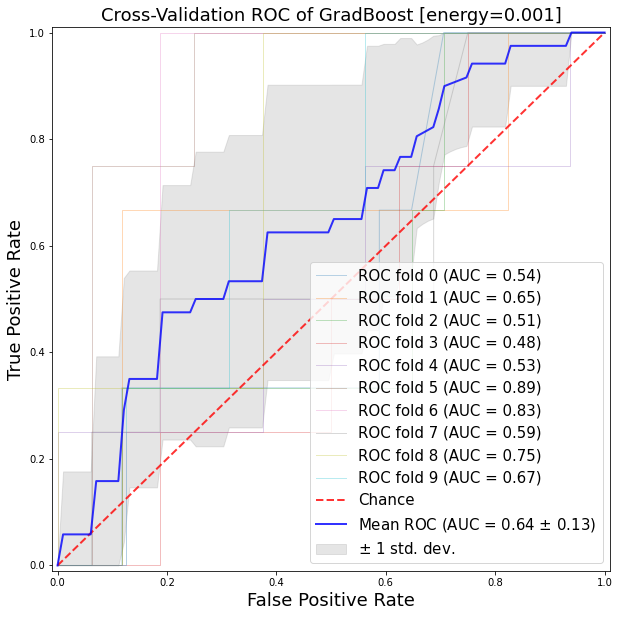

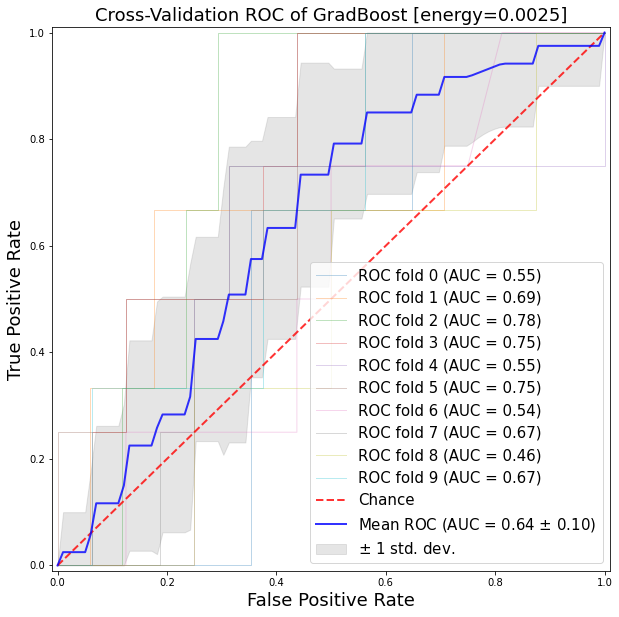

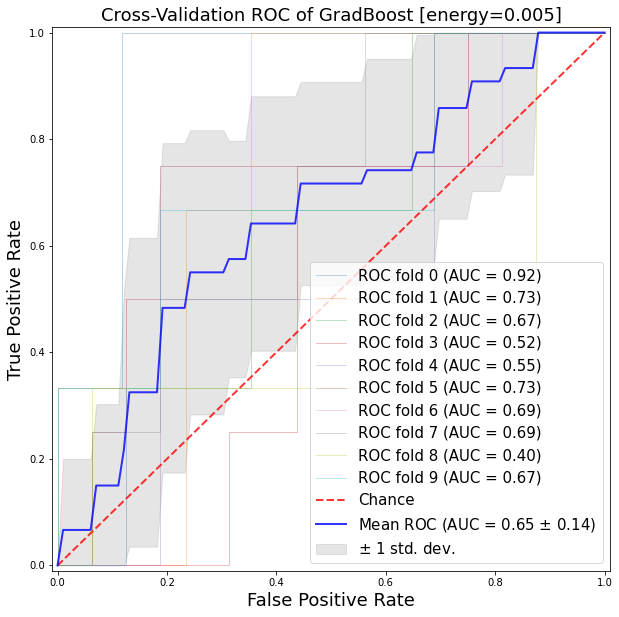

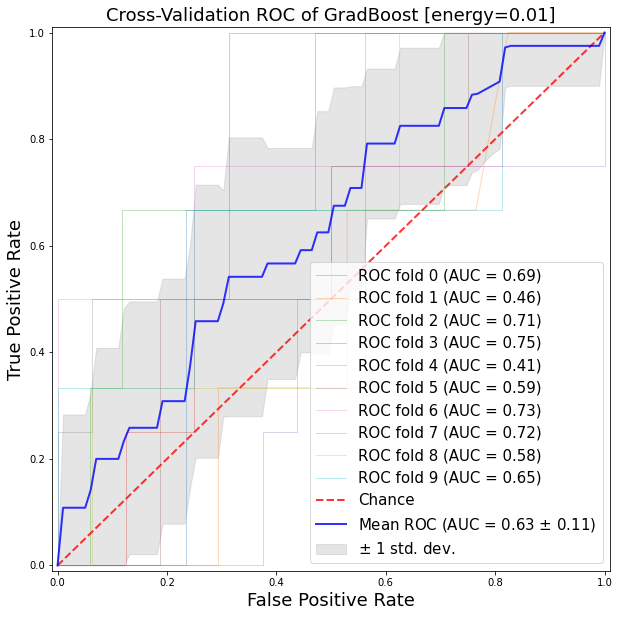

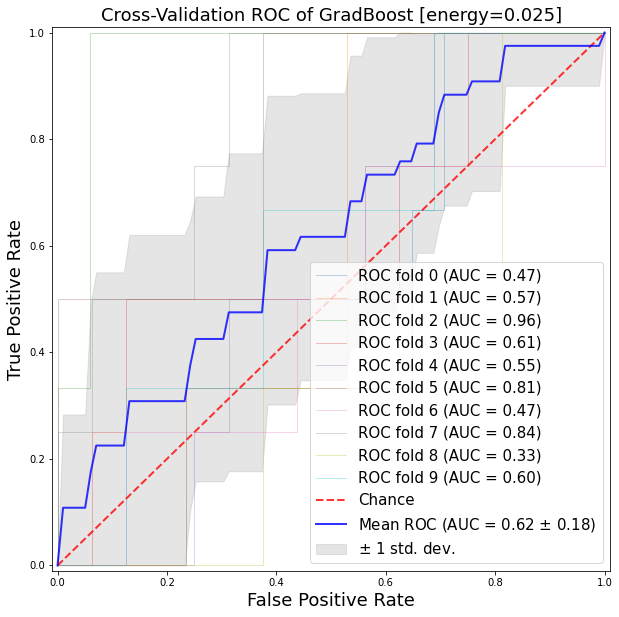

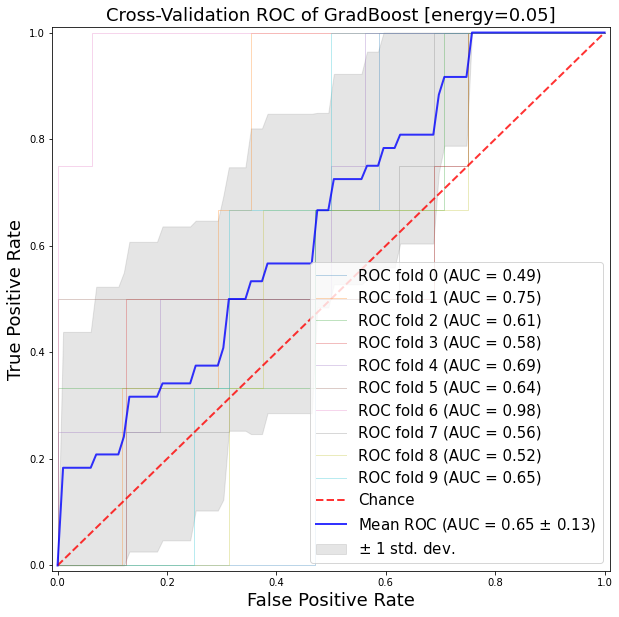

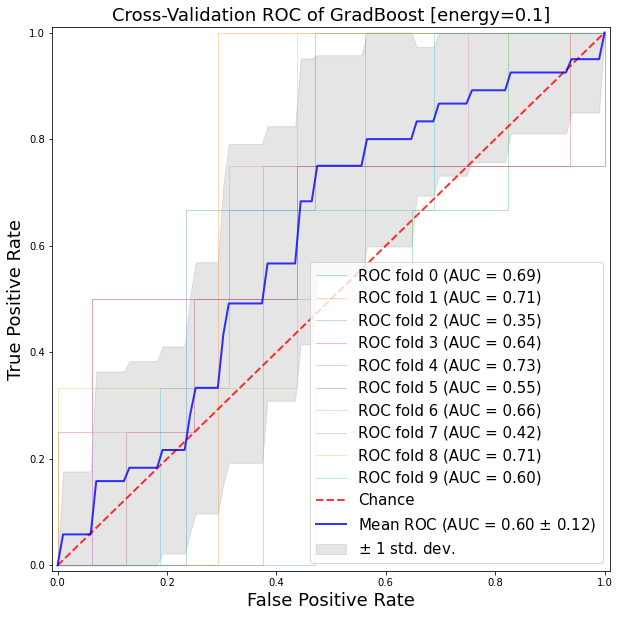

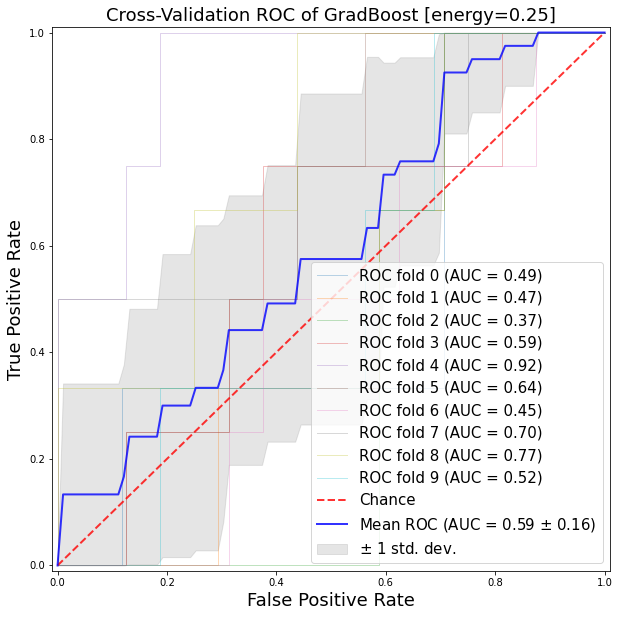

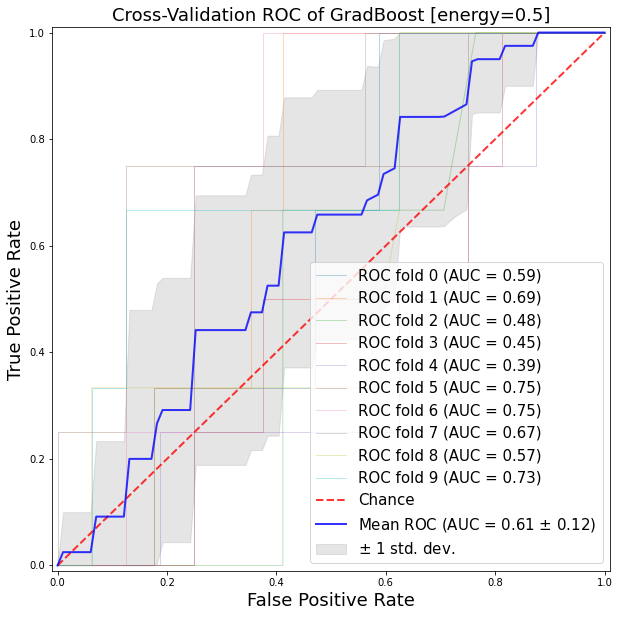

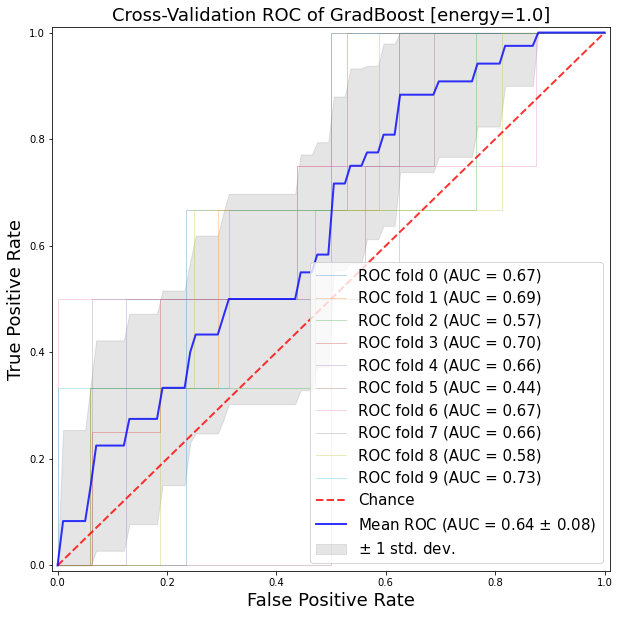

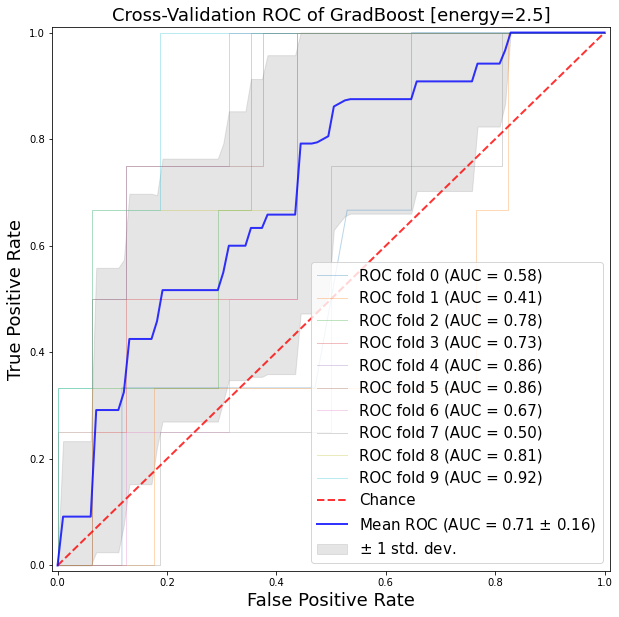

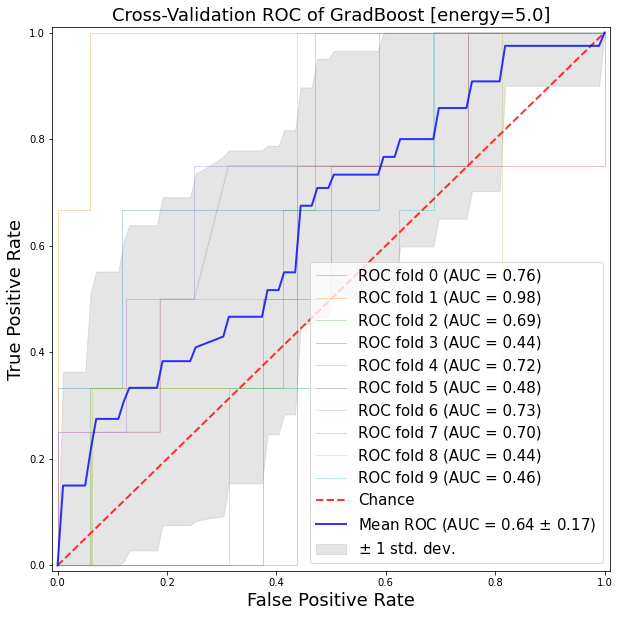

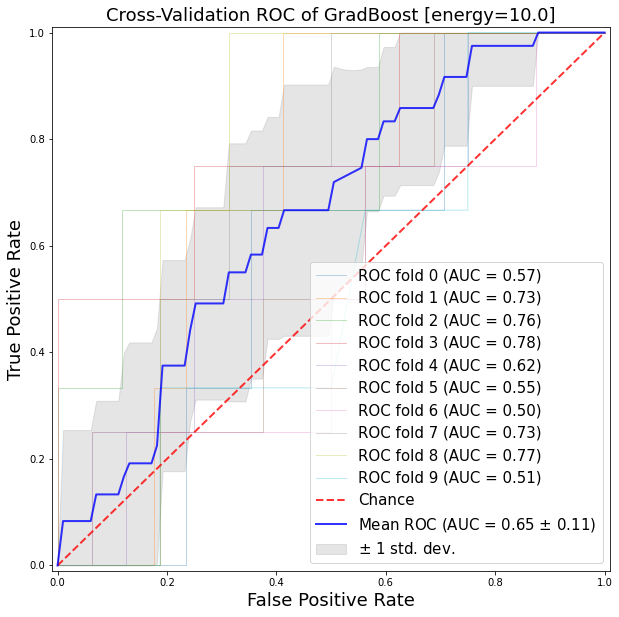

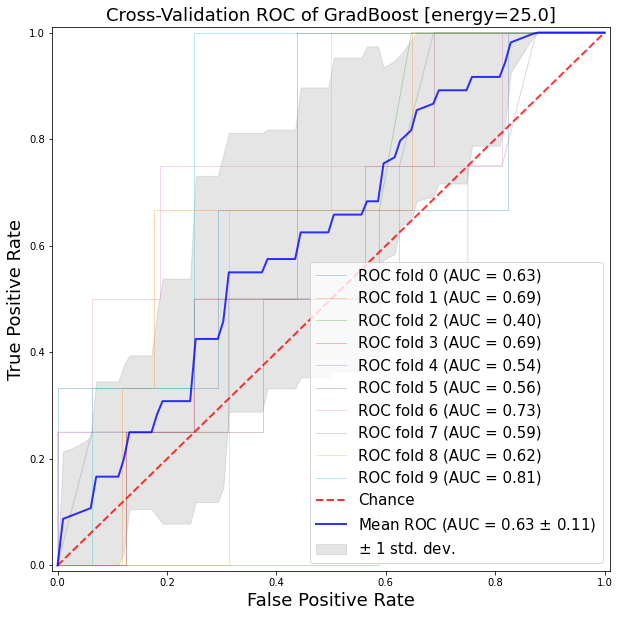

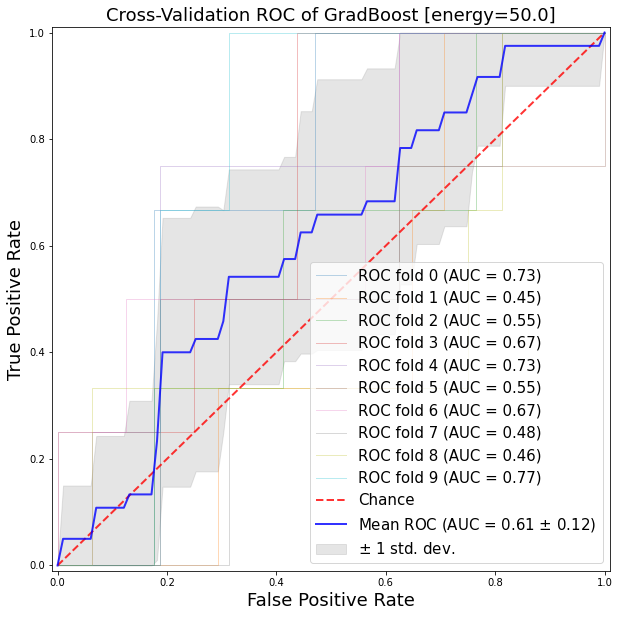

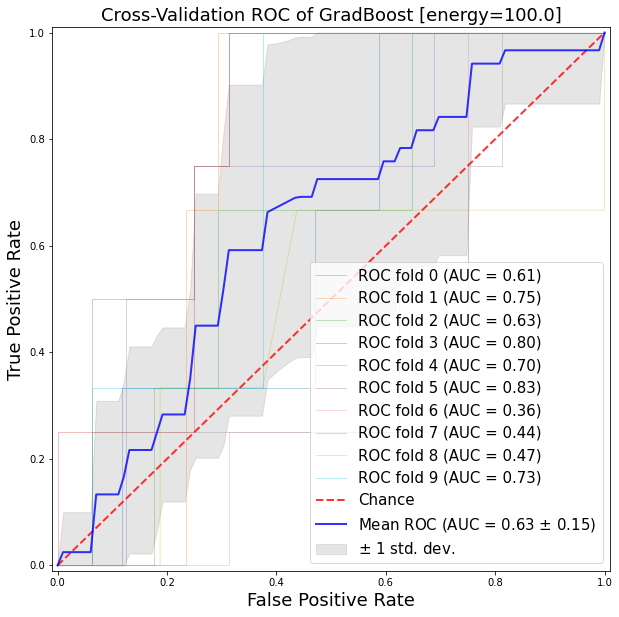

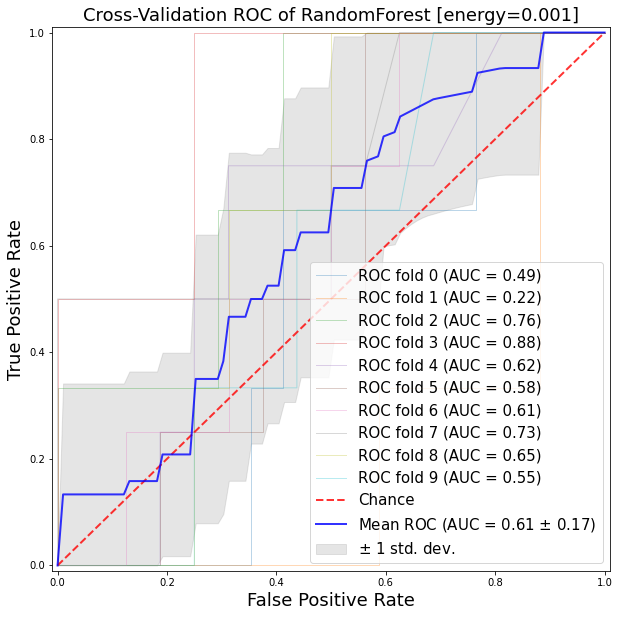

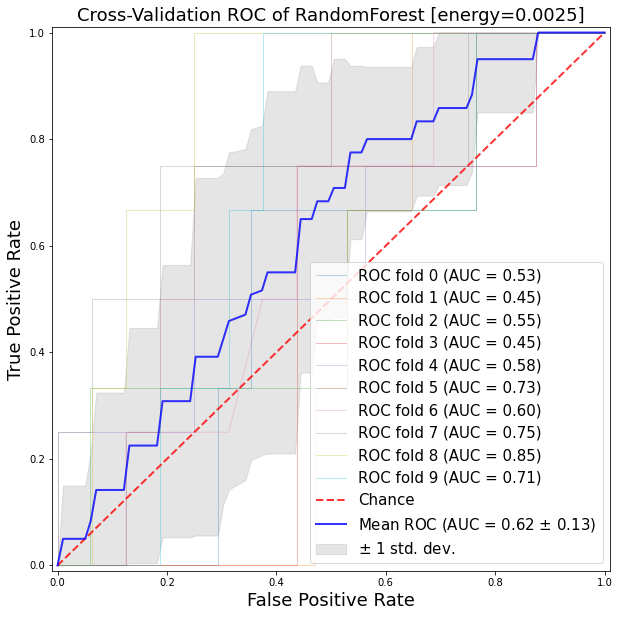

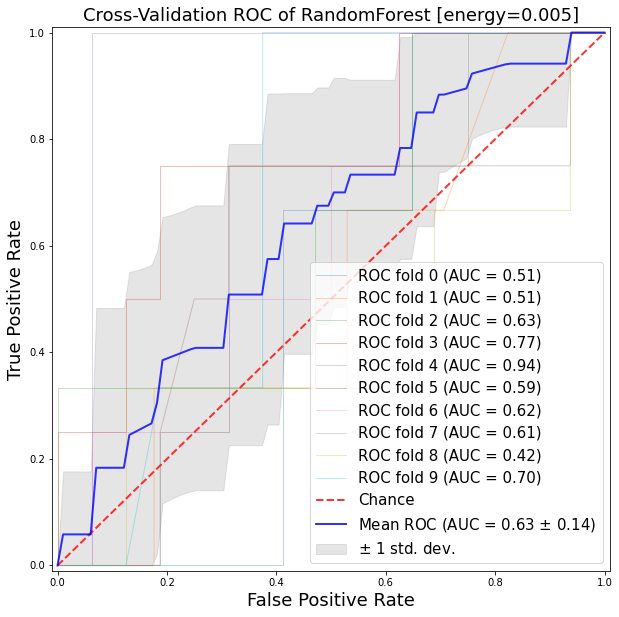

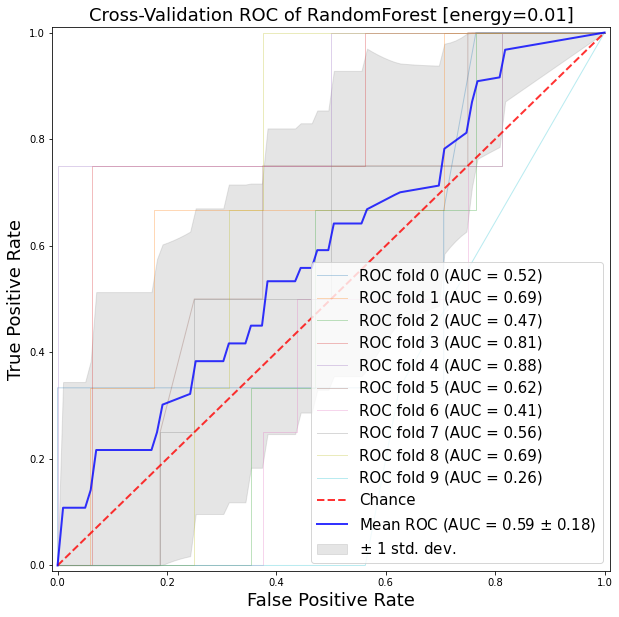

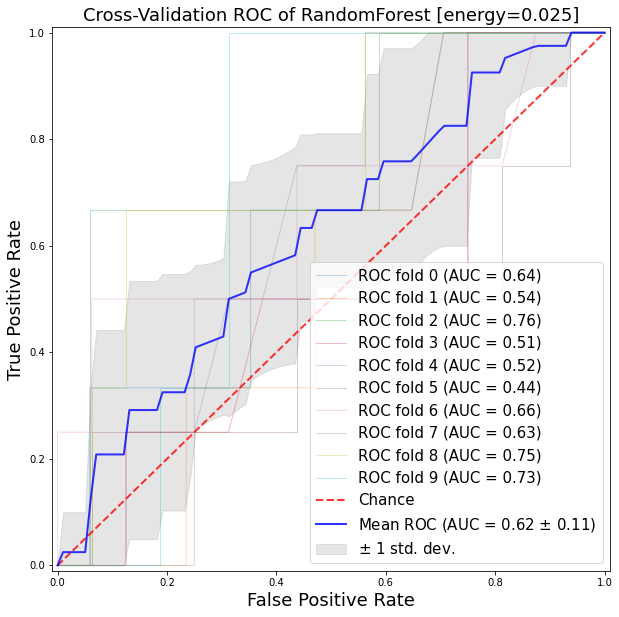

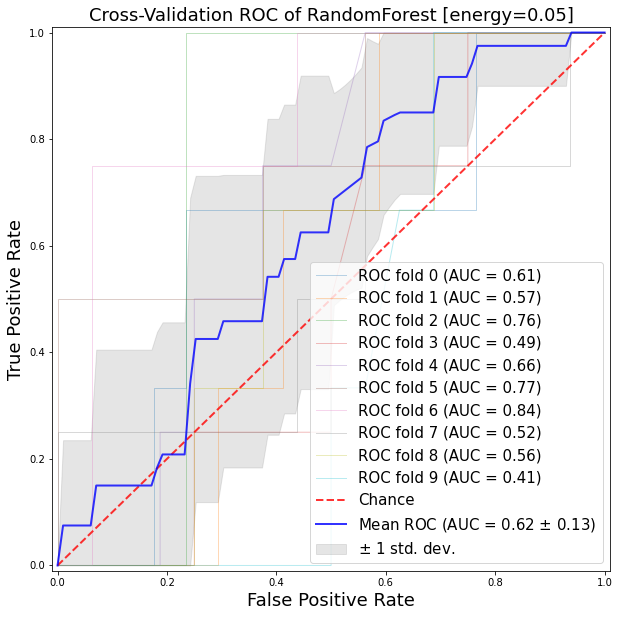

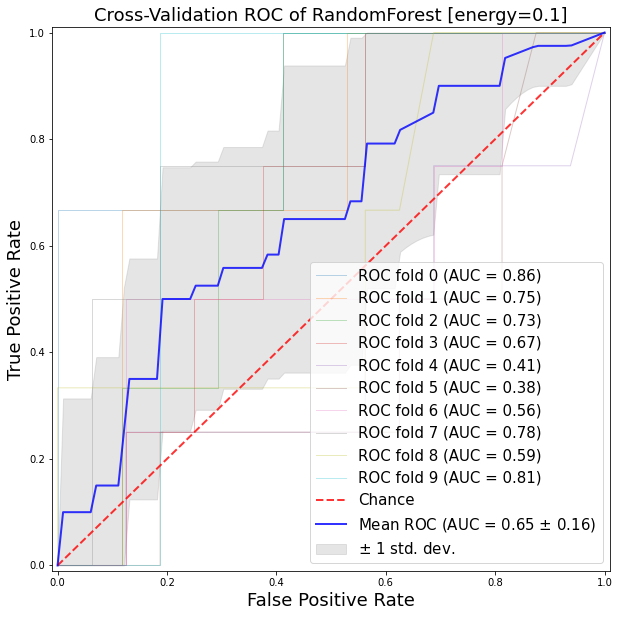

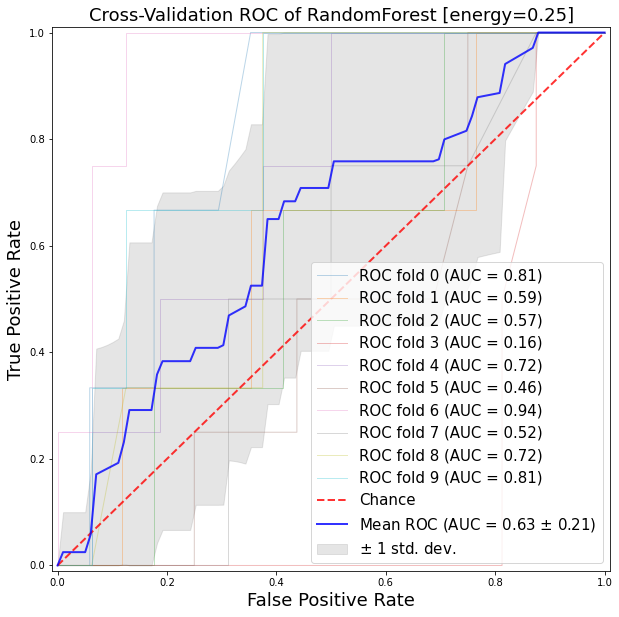

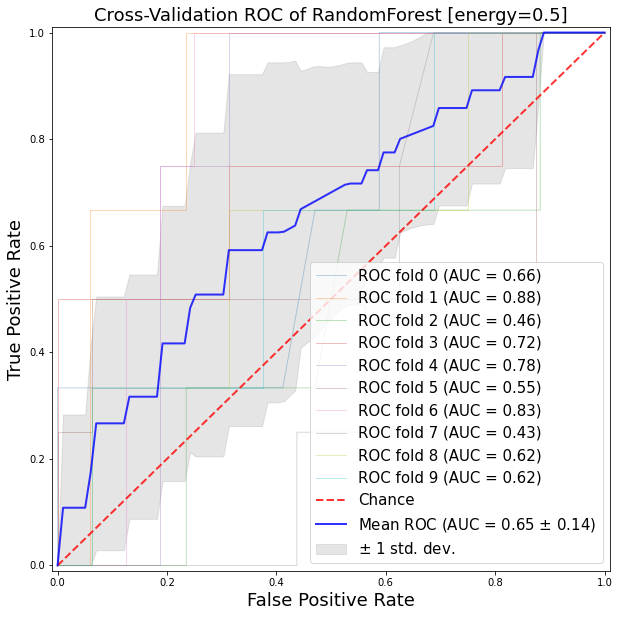

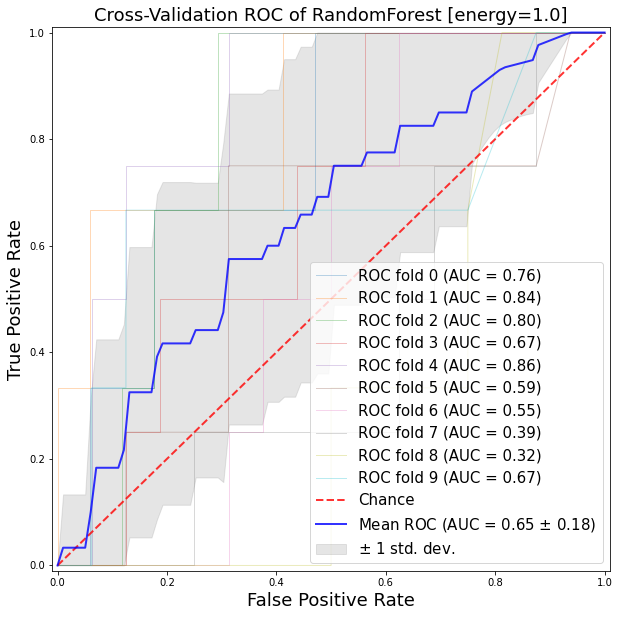

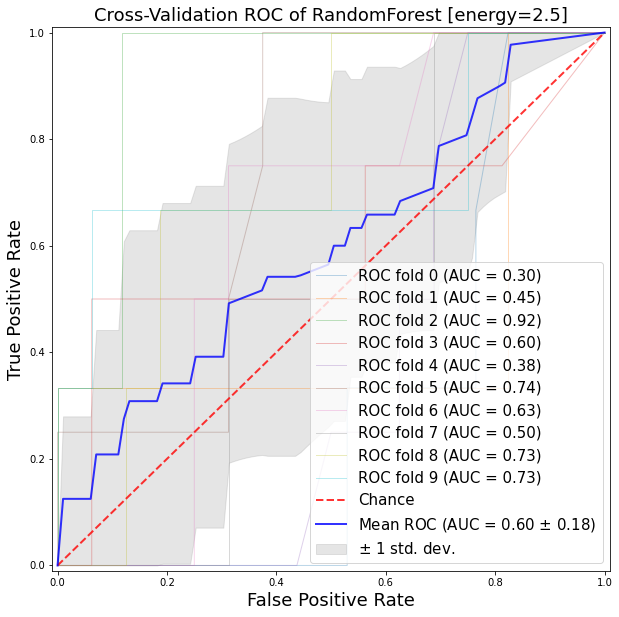

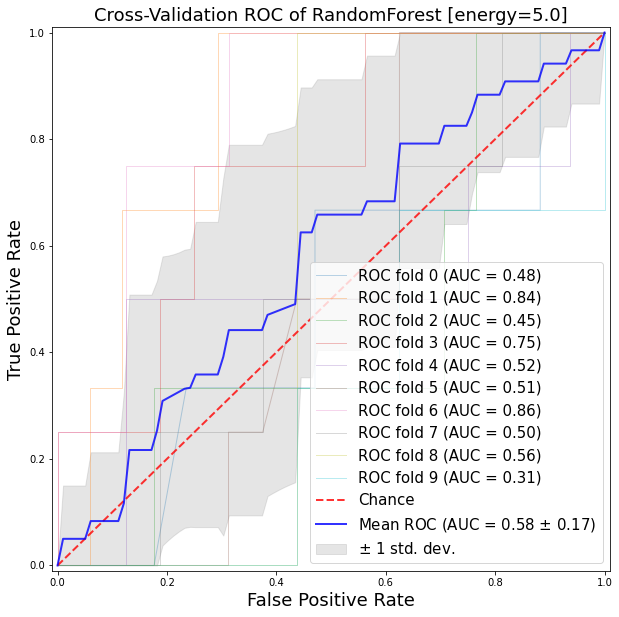

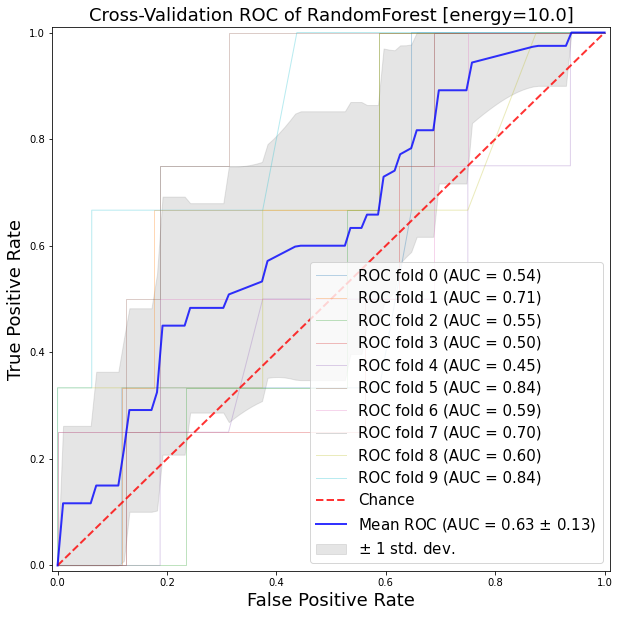

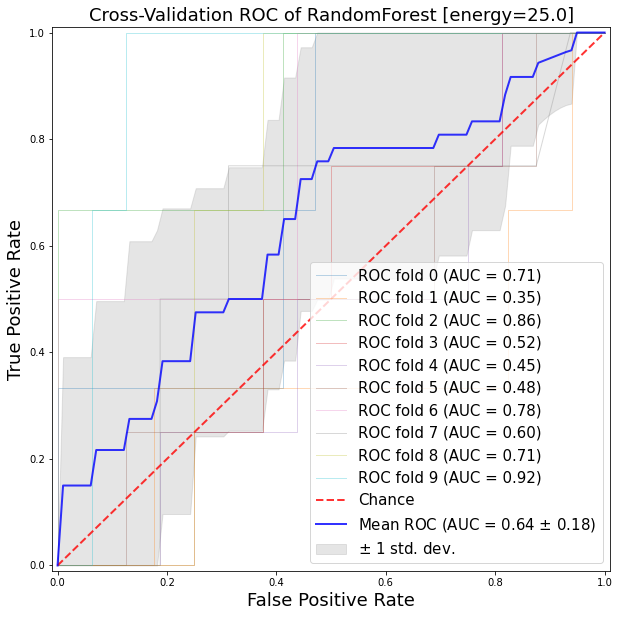

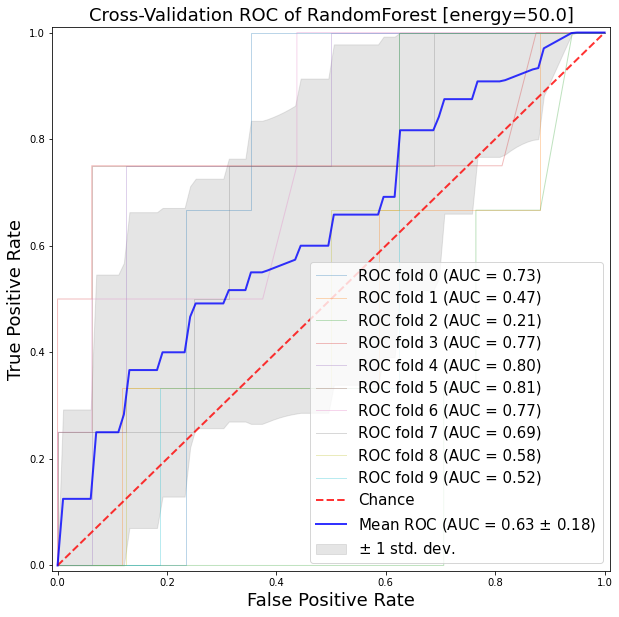

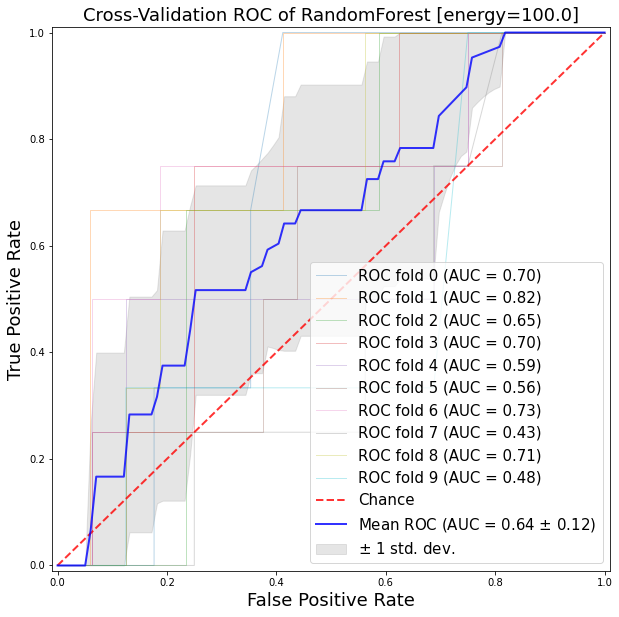

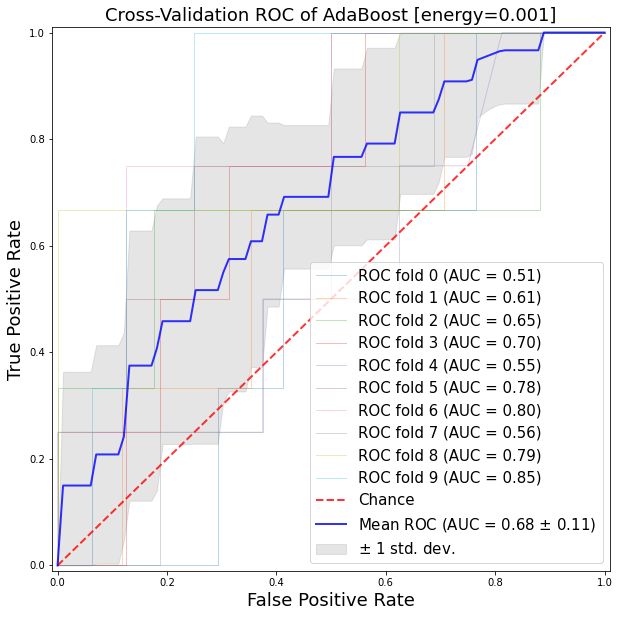

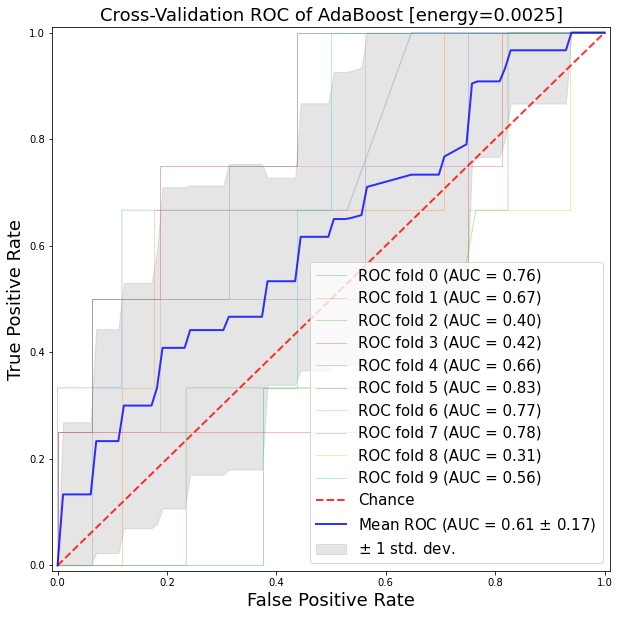

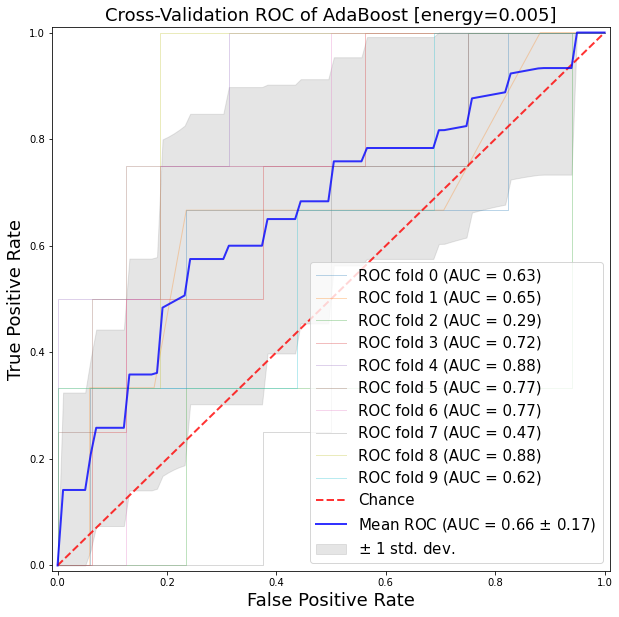

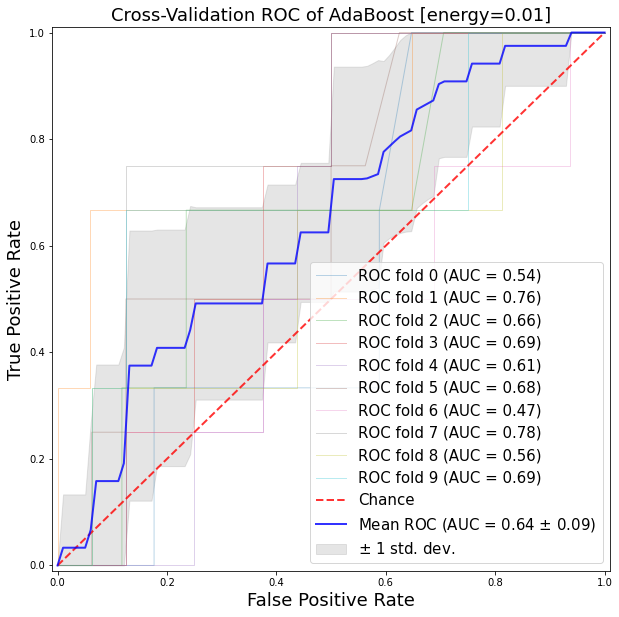

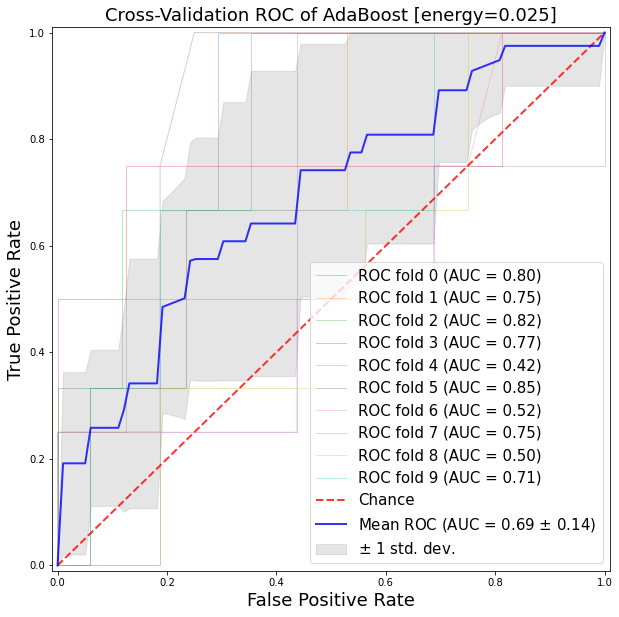

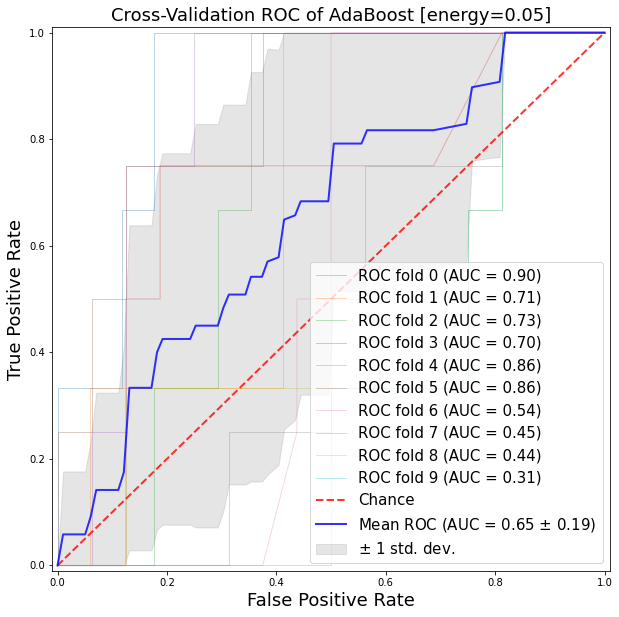

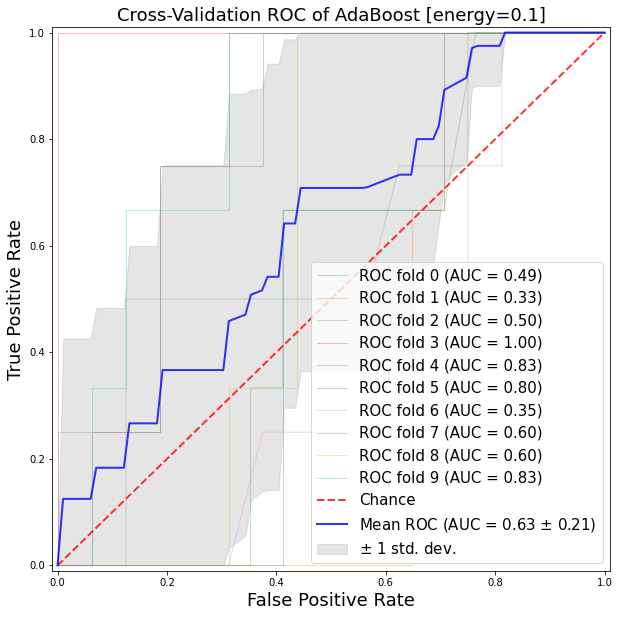

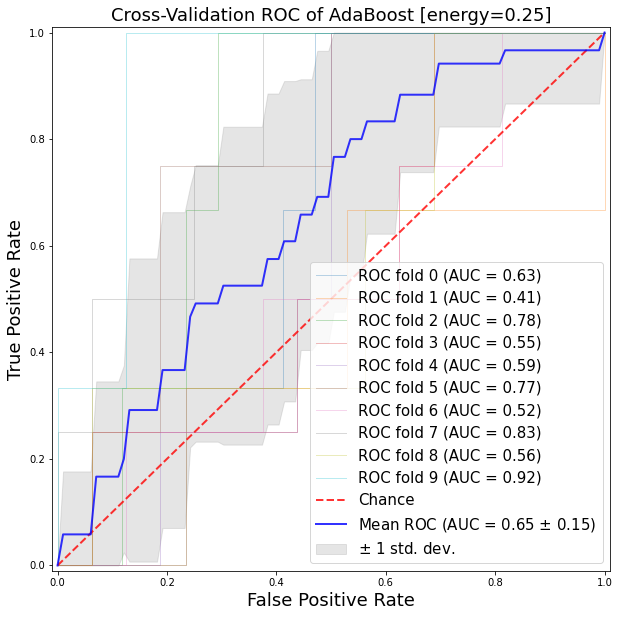

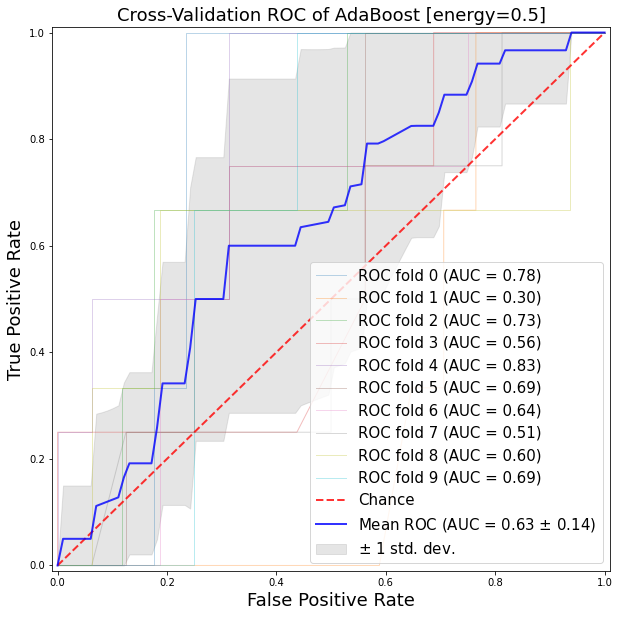

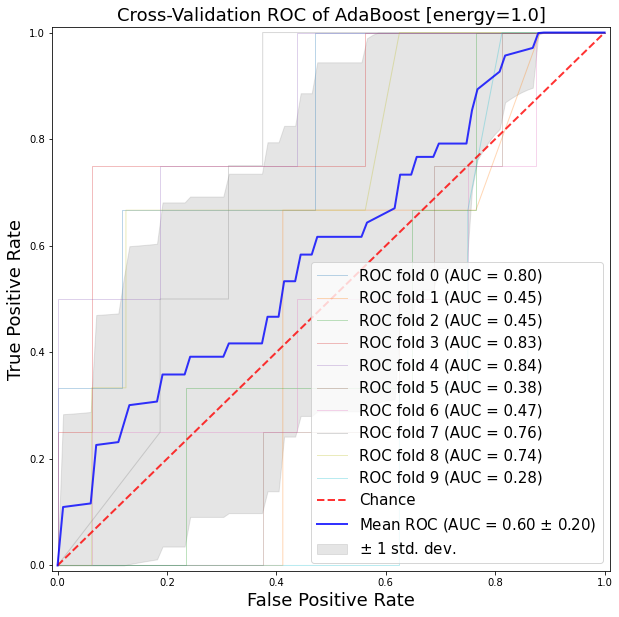

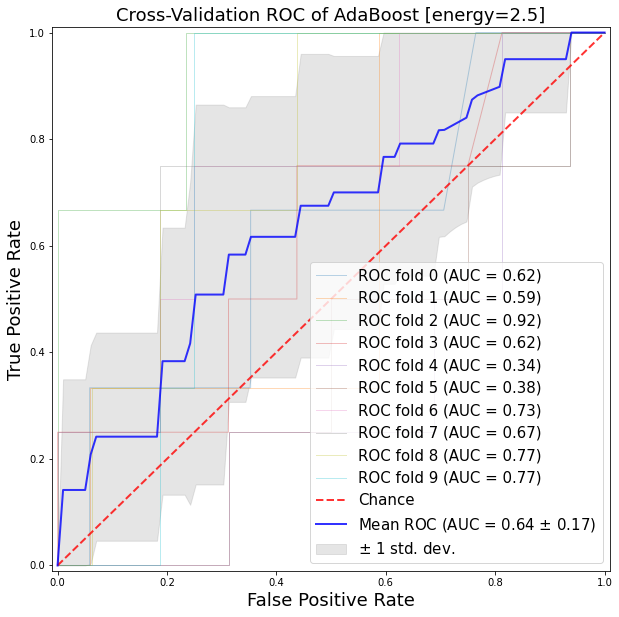

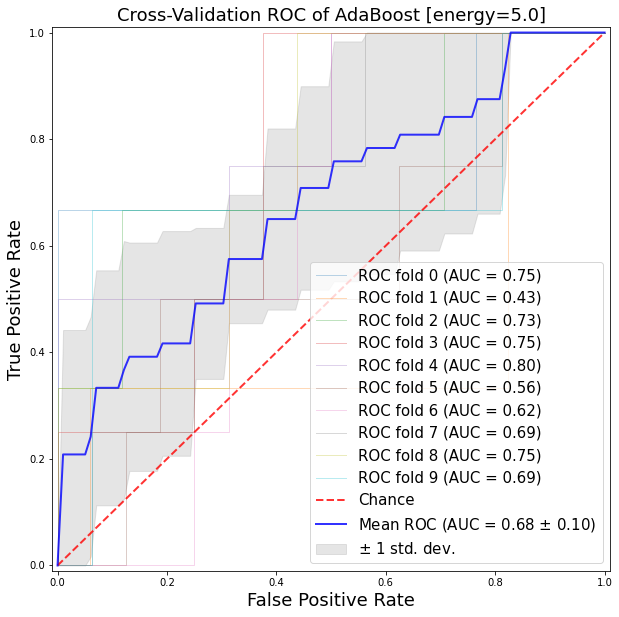

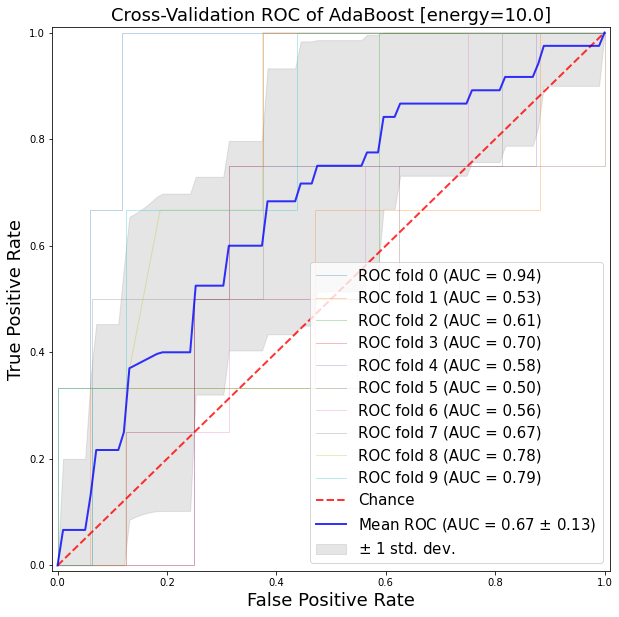

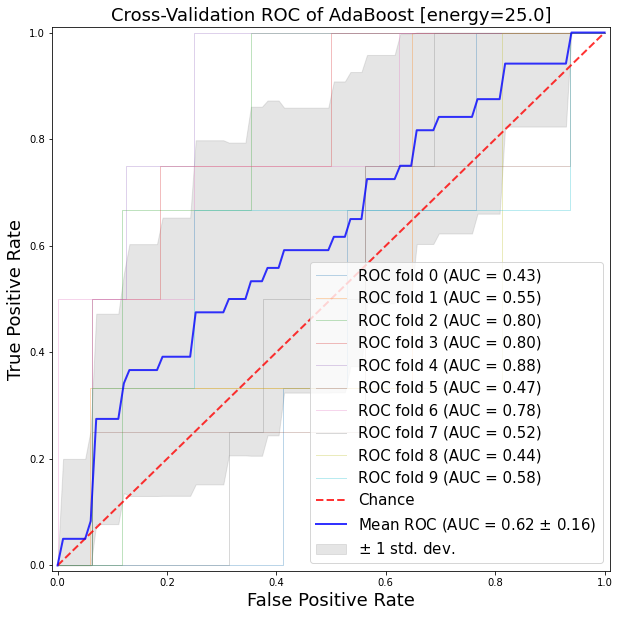

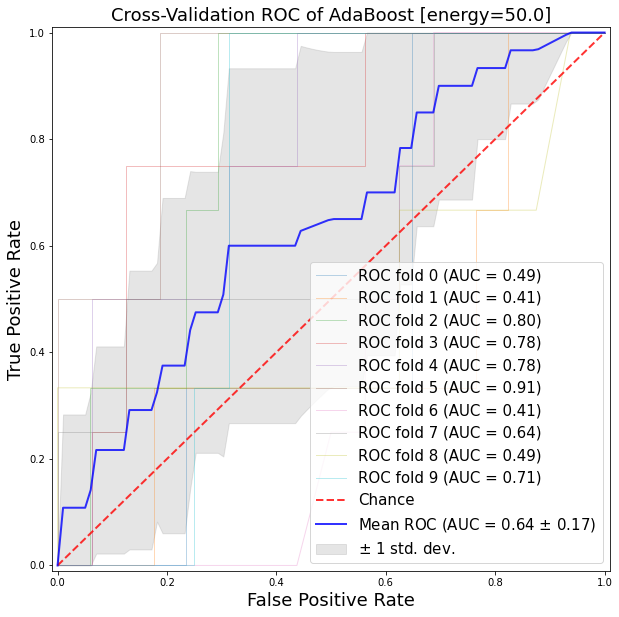

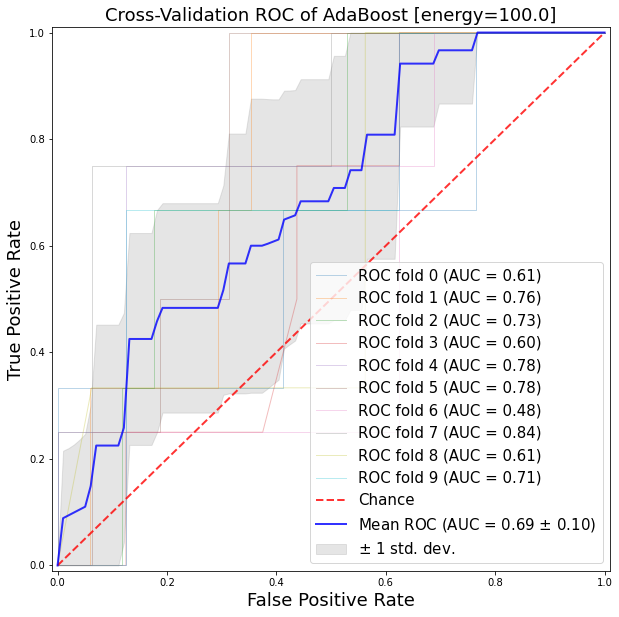

In [13]:


class Insight1():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        best_features = SelectKBest(score_func=chi2,k=10)
        fit = best_features.fit(self.X,self.y)

        dfscores = pd.DataFrame(fit.scores_)
        df_cols = pd.DataFrame(self.X.columns)

        feature_scores = pd.concat([df_cols,dfscores],axis=1)
        feature_scores.columns = ['parameters','score']
        self.selected_features = feature_scores.nlargest(10,'score').parameters.values

    
    def get_plot(self,e_class,dsname):
        e_val = [0.001, 0.0025, 0.005,0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0, 2.5, 5.0, 10.0, 25.0,50.0, 100.0]
        for c in e_class:
            os.makedirs(f"./content/drive/My Drive/src/results2/{c[1]}"+dsname)
            curr_dir = f"./content/drive/My Drive/src/results2/{c[1]}"+dsname
            for energy in e_val:
                cv = StratifiedKFold(n_splits=10,shuffle=True)
                classifier = c[0]
                y = self.y.values
                X = self.X
                X = X.loc[:,self.selected_features]
                X = X.values
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0, stratify = None)
                tprs = []
                aucs = []
                mean_fpr = np.linspace(0, 1, 100)
                plt.figure(figsize=(10,10))
                i = 0
                # cv.sh
                for train, test in cv.split(X_train, y_train):
                    # oversampler= sv.CCR()
                    oversampler= sv.CCR(proportion=1,energy=energy)    
                    X_samp, y_samp= oversampler.sample(X_train[train], y_train[train])
                    probas_ = classifier.fit(X_samp, y_samp).predict_proba(X_train[test])
                    # Compute ROC curve and area the curve
                    fpr, tpr, thresholds = metrics.roc_curve(y_train[test], probas_[:, 1])
                    tprs.append(np.interp(mean_fpr, fpr, tpr))
                    tprs[-1][0] = 0.0
                    roc_auc = metrics.auc(fpr, tpr)
                    aucs.append(roc_auc)
                    plt.plot(fpr, tpr, lw=1, alpha=0.3,
                            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

                    i += 1
                plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                        label='Chance', alpha=.8)

                mean_tpr = np.mean(tprs, axis=0)
                mean_tpr[-1] = 1.0
                mean_auc = metrics.auc(mean_fpr, mean_tpr)
                std_auc = np.std(aucs)
                plt.plot(mean_fpr, mean_tpr, color='b',
                        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                        lw=2, alpha=.8)

                std_tpr = np.std(tprs, axis=0)
                tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
                tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                                label=r'$\pm$ 1 std. dev.')

                plt.xlim([-0.01, 1.01])
                plt.ylim([-0.01, 1.01])
                plt.xlabel('False Positive Rate',fontsize=18)
                plt.ylabel('True Positive Rate',fontsize=18)
                plt.title(f'Cross-Validation ROC of {c[1]} [energy={energy}]',fontsize=18)
                plt.legend(loc="lower right", prop={'size': 15})
                # plt.show()
                plt.savefig(f'{curr_dir}/Cross-Validation_ROC_of_{c[1]} [energy={energy}.png')
# src/results/GradboostJM1
if __name__ == "__main__":
    # df = pd.read_csv("./Dataset/JM1.csv")
    # df['label'] = df['label'].map({"b'N'" :False,"b'Y'" :True})
    # df = pd.read_csv("./Dataset/KC3.csv")
    df= pd.read_csv('/content/drive/My Drive/Dataset/KC3.csv')
    df['Defective'] = df['Defective'].map({"b'N'" :False,"b'Y'" :True})
    X = df
    # X = X.drop('label',axis=1)
    # y = df['label']
    X = X.drop('Defective',axis=1)
    y = df['Defective']
    
    o = Insight1(X,y)
    # o.get_plot([])
    # o.get_plot([AdaBoostClassifier(n_estimators=200)])
    # o.get_plot([RandomForestClassifier(n_estimators=200)])
    clfs = [(GradientBoostingClassifier(n_estimators=200),"GradBoost"),(RandomForestClassifier(n_estimators=200),"RandomForest"),(AdaBoostClassifier(n_estimators=200),"AdaBoost")]
    o.get_plot(clfs,"KC3")



    # pass
